In [118]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils.data_utils import load_dataset ,load_file, split_ids
from utils.plot_utils import plot_targets
from utils.preprocessing import create_batch_sequences, create_sequences
from utils.evaluate import compare_events
from scipy.signal import find_peaks

For each valid trial, the relevant data and information are saved in **five** different data files:
- sub-\<label\>_task-\<label\>[_run-\<label\>]_events.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-imu_motion.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_channels.tsv
- sub-\<label\>_task-\<label\>[_run-\<label\>]_tracksys-omc_motion.tsv

As we only consinder **walk** trials, we can look for any **_events.tsv** file that contains **_task-walk** in the filename.

In [4]:
# Set root directory
root_dir = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata" if sys.platform == "linux" else "Z:\\Keep Control\\Data\\lab dataset\\rawdata"

# Split subjects into a train, validation, and test set
train_ids, val_ids, test_ids = split_ids(root_dir, by=["gender", "participant_type"])
print(f"# of subjects in train set: {len(train_ids):d}\t{train_ids[:5]}")
print(f"# of subjects in val set: {len(val_ids):d}\t{val_ids[:5]}")
print(f"# of subjects in test set: {len(test_ids):d}\t{test_ids[:5]}")

# of subjects in train set: 62	['sub-pp155', 'sub-pp157', 'sub-pp047', 'sub-pp039', 'sub-pp165']
# of subjects in val set: 49	['sub-pp168', 'sub-pp156', 'sub-pp147', 'sub-pp125', 'sub-pp106']
# of subjects in test set: 49	['sub-pp167', 'sub-pp135', 'sub-pp153', 'sub-pp126', 'sub-pp099']


In [5]:
# Get datasets
ds_train = load_dataset(root_dir, sub_ids=train_ids, tracked_points=["left_ankle", "right_ankle"], normalize=True)
ds_val = load_dataset(root_dir, sub_ids=val_ids, tracked_points=["left_ankle", "right_ankle"], normalize=True)
ds_test = load_dataset(root_dir, sub_ids=test_ids, tracked_points=["left_ankle", "right_ankle"], normalize=True)

/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp164/motion/sub-pp164_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp164/motion/sub-pp164_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp164/motion/sub-pp164_task-walkSlow_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp162/motion/sub-pp162_task-walkFast_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp162/motion/sub-pp162_task-walkPreferred_events.tsv contains no data for (at least) the left_ankle sensor. Skip file.
/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset/rawdata/sub-pp162/motion

In [6]:
WIN_LEN = 400
STEP_LEN = 200
train_data, train_targets, train_examples = create_batch_sequences(ds_train, win_len=WIN_LEN, step_len=STEP_LEN)
val_data, val_targets, val_examples = create_batch_sequences(ds_val, win_len=WIN_LEN, step_len=STEP_LEN)

## Build model

In [7]:
from tensorflow import keras
from tcn import TCN, tcn_full_summary

In [8]:
def build_model(input_dim, target_classes):
    # Define layers
    inputs = keras.layers.Input(shape=(None, input_dim), name="inputs")
    tcn = TCN(nb_filters=16, kernel_size=5, nb_stacks=1, dilations=[1, 2], padding="same", use_skip_connections=True, use_batch_norm=True, return_sequences=True, name="tcn")(inputs)
    outputs = []
    for i in range(len(target_classes)):
        outputs.append(keras.layers.Dense(units=1, activation="sigmoid", name=target_classes[i])(tcn))
    
    # Instantiate model
    model = keras.models.Model(inputs=inputs, outputs=outputs, name="tcn_model")

    # Compile
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

In [9]:
model = build_model(train_data.shape[-1], target_classes=list(train_targets.keys()))
model.summary()

2022-02-22 15:15:14.365116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 15:15:14.424536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 15:15:14.424680: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-22 15:15:14.425604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "tcn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 9)]    0           []                               
                                                                                                  
 tcn (TCN)                      (None, None, 16)     5040        ['inputs[0][0]']                 
                                                                                                  
 initial_contact (Dense)        (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                                  
 final_contact (Dense)          (None, None, 1)      17          ['tcn[0][0]']                    
                                                                                          

In [10]:
history = model.fit(x=train_data, y=train_targets, batch_size=8, epochs=5, validation_data=(val_data, val_targets))

Epoch 1/5


2022-02-22 15:15:47.831748: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-02-22 15:15:48.553858: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


199/199 [==============================] - 5s 8ms/step - loss: 0.0770 - initial_contact_loss: 0.0585 - final_contact_loss: 0.0185 - val_loss: 0.0378 - val_initial_contact_loss: 0.0227 - val_final_contact_loss: 0.0151
Epoch 2/5
199/199 [==============================] - 1s 6ms/step - loss: 0.0231 - initial_contact_loss: 0.0133 - final_contact_loss: 0.0099 - val_loss: 0.0226 - val_initial_contact_loss: 0.0121 - val_final_contact_loss: 0.0104
Epoch 3/5
199/199 [==============================] - 1s 6ms/step - loss: 0.0187 - initial_contact_loss: 0.0104 - final_contact_loss: 0.0083 - val_loss: 0.0193 - val_initial_contact_loss: 0.0100 - val_final_contact_loss: 0.0093
Epoch 4/5
199/199 [==============================] - 1s 6ms/step - loss: 0.0168 - initial_contact_loss: 0.0094 - final_contact_loss: 0.0074 - val_loss: 0.0182 - val_initial_contact_loss: 0.0092 - val_final_contact_loss: 0.0090
Epoch 5/5
199/199 [==============================] - 1s 6ms/step - loss: 0.0157 - initial_contact_loss

In [11]:
predictions = model.predict(val_data, batch_size=8)

In [13]:
val_targets.keys()

dict_keys(['initial_contact', 'final_contact'])

0: initial_contact
1: final_contact


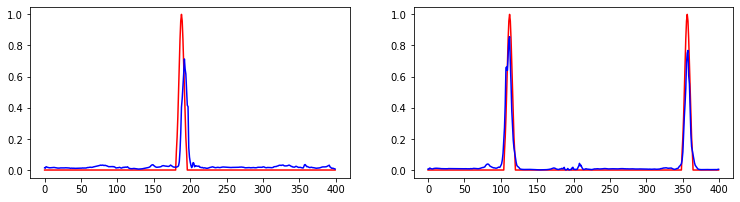

In [17]:
ix_example = np.random.choice(val_data.shape[0], 1, replace=False)[0]

cm = 1/2.54
fig, axs = plt.subplots(1, len(val_targets.keys()), figsize=(32*cm, 8*cm))
for i, k in enumerate(val_targets.keys()):
    print(f"{i:d}: {k:s}")
    axs[i].plot(np.arange(val_targets[k][ix_example].shape[0]), val_targets[k][ix_example], 'r')
    axs[i].plot(np.arange(predictions[i][ix_example].shape[0]), predictions[i][ix_example], 'b')
# plt.plot(val_targets["final_contact_right"][indx_example][:,0], label='true')
# plt.plot(predictions[3][indx_example][:,0], label='pred')

# plt.grid()
# plt.legend()
plt.show()

### Evaluate on test set

In [108]:
def fancy_plot(ds_test, ix_sub_id, predictions, ix_IC_pred, ix_FC_pred):
    cm = 1/2.54

    fig, axs = plt.subplots(1+len(ds_test[ix_sub_id]["targets"].keys()), 1, figsize=(16*cm, 9*cm), sharex=True, gridspec_kw={"height_ratios": [3, 1, 1]})
    axs[0].plot(np.arange(ds_test[ix_sub_id]["data"].shape[0]), ds_test[ix_sub_id]["data"][:,5], ls="-", c=(0, 0, 0), alpha=0.3)
    axs[0].plot(np.argwhere(ds_test[ix_sub_id]["targets"]["initial_contact"]==1)[:,0], ds_test[ix_sub_id]["data"][np.argwhere(ds_test[ix_sub_id]["targets"]["initial_contact"]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(0, 0, 1))
    axs[0].plot(np.argwhere(ds_test[ix_sub_id]["targets"]["final_contact"]==1)[:,0], ds_test[ix_sub_id]["data"][np.argwhere(ds_test[ix_sub_id]["targets"]["final_contact"]==1)[:,0],5], ls="none", marker="o", mfc="none", mec=(0, 0.65, 0))
    axs[0].xaxis.set_minor_locator(plt.MultipleLocator(10))
    axs[0].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[0].set_xlim([0, ds_test[ix_sub_id]["data"].shape[0]])

    axs[1].plot(np.arange(ds_test[ix_sub_id]["targets"]["initial_contact"].shape[0]), ds_test[ix_sub_id]["targets"]["initial_contact"][:,0], ls="-", c=(0, 0, 1), lw=2, alpha=0.2)
    axs[1].plot(np.arange(predictions[0][0].shape[0]), predictions[0][0][:,0], ls="-", lw=1, c=(0, 0, 1))
    axs[1].plot(ix_IC_pred, predictions[0][0][ix_IC_pred,0], ls="none", marker="o", mfc="none", mec=(0, 0, 1))
    axs[1].set_ylim([0.1, 1.1])
    axs[1].set_yticks([0, 1])
    axs[1].set_ylabel("Pr(IC)")
    axs[1].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[1].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")

    axs[2].plot(np.arange(ds_test[ix_sub_id]["targets"]["final_contact"].shape[0]), ds_test[ix_sub_id]["targets"]["final_contact"][:,0], ls="-", c=(0, 0.65, 0), lw=2, alpha=0.2)
    axs[2].plot(np.arange(predictions[1][0].shape[0]), predictions[1][0][:,0], ls="-", lw=1, c=(0, 0.65, 0))
    axs[2].plot(ix_FC_pred, predictions[1][0][ix_FC_pred,0], ls="none", marker="o", mfc="none", mec=(0, 0.65, 0))
    axs[2].set_ylim([0.1, 1.1])
    axs[2].set_yticks([0, 1])
    axs[2].set_ylabel("Pr(FC)")
    axs[2].yaxis.set_minor_locator(plt.MultipleLocator(0.25))
    axs[2].grid(which="both", axis="both", c=(0, 0, 0), alpha=0.1, ls=":")
    axs[2].set_xlabel("sample")

    plt.tight_layout()
    plt.savefig(os.path.join("/home/robbin/Desktop/fig/20220222", ds_test[ix_sub_id]["filename_prefix"]+"_predictions.png"), dpi=300)
    return

In [135]:
# ix_sub_id = np.random.choice(len(ds_test), 1, replace=False)[0]
ix_sub_id = 2
X_in = ds_test[ix_sub_id]["data"]
X_in = np.expand_dims(X_in, axis=0)
predictions = model.predict(X_in)

In [136]:
ix_IC_true, _ = find_peaks(ds_test[ix_sub_id]["targets"]["initial_contact"][:,0], height=0.5, distance=100)
ix_FC_true, _ = find_peaks(ds_test[ix_sub_id]["targets"]["final_contact"][:,0], height=0.5, distance=100)
ix_IC_pred, _ = find_peaks(predictions[0][0][:,0], height=0.5, distance=100)
ix_FC_pred, _ = find_peaks(predictions[1][0][:,0], height=0.5, distance=100)

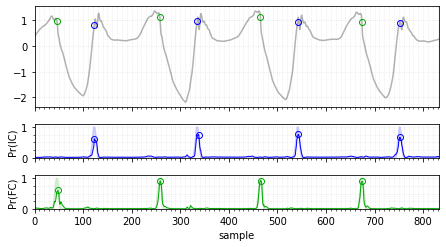

In [137]:
fancy_plot(ds_test=ds_test, ix_sub_id=ix_sub_id, predictions=predictions, ix_IC_pred=ix_IC_pred, ix_FC_pred=ix_FC_pred)

In [138]:
ann2pred, pred2ann, dt = compare_events(ix_IC_true, ix_IC_pred)

# Loop over the true events
for i in range(len(ix_IC_true)):
    if ann2pred[i] > -999:
        print(f"{ix_IC_true[i]:>6d} : {ix_IC_pred[ann2pred[i]]}")
    else:
        print(f"{ix_IC_true[i]:>6d} : {'n/a':s}")
for j in range(len(ix_IC_pred)):
    if pred2ann[j] == -999:
        print(f"{'n/a':>6s} : {ix_IC_pred[j]}")

   123 : 123
   335 : 338
   542 : 543
   752 : 752


In [139]:
ann2pred, pred2ann, dt = compare_events(ix_FC_true, ix_FC_pred)

# Loop over the true events
for i in range(len(ix_FC_true)):
    if ann2pred[i] > -999:
        print(f"{ix_FC_true[i]:>6d} : {ix_FC_pred[ann2pred[i]]}")
    else:
        print(f"{ix_FC_true[i]:>6d} : {'n/a':s}")
for j in range(len(ix_FC_pred)):
    if pred2ann[j] == -999:
        print(f"{'n/a':>6s} : {ix_FC_pred[j]}")

    46 : 48
   258 : 259
   465 : 466
   674 : 674
